In [1]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# numerical computation
import numpy as np

# data processing/manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import re
from unidecode import unidecode 
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from collections import Counter
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
%matplotlib inline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary 
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# spacy for lemmatization and additional stopwords
import spacy
#import en_core_web_sm
#nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS

# LDA plotting tools
import pyLDAvis
import pyLDAvis.sklearn 
import pyLDAvis.gensim_models

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## 1. Read and preprocess Data

In [4]:
# Loading each dataset
trump_df = pd.read_csv('hashtag_donaldtrump.csv', lineterminator='\n')
biden_df = pd.read_csv('hashtag_joebiden.csv', lineterminator='\n')

In [5]:
pd.options.display.max_colwidth = 1000

In [6]:
print('Total number of records in Trump dataset: ', trump_df.shape)
print('Total number of records in Biden dataset: ', biden_df.shape)

Total number of records in Trump dataset:  (970919, 21)
Total number of records in Biden dataset:  (776886, 21)


In [7]:
# Getting some insights on trump_df dataset 
trump_df.describe()

,tweet_id,likes,retweet_count,user_id,user_followers_count,lat,long
count,9.709190e+05,970919.000000,970919.000000,9.709190e+05,9.709190e+05,445719.000000,445719.000000
mean,1.322494e+18,7.477011,1.698500,4.468311e+17,2.260357e+04,35.697936,-40.369638
std,2.555133e+15,158.058117,40.028419,5.544702e+17,3.042152e+05,18.823129,67.531751
min,1.316529e+18,0.000000,0.000000,5.310000e+02,0.000000e+00,-90.000000,-175.202642
25%,1.320478e+18,0.000000,0.000000,2.169326e+08,7.700000e+01,32.701939,-96.796856
50%,1.323612e+18,0.000000,0.000000,2.373392e+09,4.410000e+02,39.783730,-74.006015
75%,1.324505e+18,1.000000,0.000000,1.078344e+18,2.066000e+03,46.603354,6.776314
max,1.325589e+18,74084.000000,20491.000000,1.325581e+18,1.911533e+07,90.000000,179.048837


In [8]:
# Remove unneeded columns
#irrelevant_columns = ['tweet_id','user_id','user_name','user_screen_name','user_description','user_join_date','collected_at']

#a more conservative way of considering which columns are not relevant
#irrelevant_columns = ['collected_at']
irrelevant_columns = ['user_name','user_screen_name','user_description','user_join_date','collected_at']
trump_df = trump_df.drop(columns=irrelevant_columns)
biden_df = biden_df.drop(columns=irrelevant_columns)

# Renaming columns
trump_df = trump_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})
biden_df = biden_df.rename(columns={"likes": "Likes", "retweet_count": "Retweets", 
                                    "state": "State", "user_followers_count": "Followers"})

# Update United States country name for consistency
d = {"United States of America":"United States"}
trump_df['country'].replace(d, inplace=True)
biden_df['country'].replace(d, inplace=True)

trump_df = trump_df.loc[trump_df['country'] == "United States"]
biden_df = biden_df.loc[biden_df['country'] == "United States"]

# Drop null rows
trump_df = trump_df.dropna()
biden_df = biden_df.dropna()

In [9]:
# Filter on tweets that are within the Unites States
trump_usa_df = trump_df[trump_df['country'] == 'United States']
biden_usa_df = biden_df[biden_df['country'] == 'United States']

In [10]:
del trump_df
del biden_df

In [11]:
print('Total number of records in Trump dataset in USA only: ', trump_usa_df.shape)
print('Total number of records in Biden dataset in USA only: ', biden_usa_df.shape)

Total number of records in Trump dataset in USA only:  (101953, 16)
Total number of records in Biden dataset in USA only:  (90639, 16)


In [12]:
trump_usa_df['initial_dataset'] = 'trump'
biden_usa_df['initial_dataset'] = 'biden'

# Combine the filtered on United States Trump and Biden Datasets 
twitter_usa_df = pd.concat([trump_usa_df,biden_usa_df],ignore_index=True)

# Get duplicates
twitter_usa_df_duplicates = twitter_usa_df[twitter_usa_df.duplicated(['tweet_id'], keep=False)]

#remove tweets with these ids from trump_usa_df and biden_usa_df
trump_usa_df = trump_usa_df[~trump_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]
biden_usa_df = biden_usa_df[~biden_usa_df.tweet_id.isin(twitter_usa_df_duplicates.tweet_id)]

# Drop duplicates of tweets that relate to trump and biden 
twitter_usa_df.drop_duplicates(subset ="tweet_id", keep = False, inplace = True) #we remove them completely

# Check number of rows in combined dataset
twitter_usa_df.shape

(152376, 17)

In [13]:
print('Trump: ', sum(twitter_usa_df.initial_dataset == 'trump'))
print('Biden: ', sum(twitter_usa_df.initial_dataset == 'biden'))

Trump:  81884
Biden:  70492


## 2. Exploratory Data Analysis

### Preprocessing Tweets
- lowercasing
- remove links, special char, punctuation ...
- Tokenisation
- stopword removal

In [14]:
'''
Helper function that:
    - removes accents
    - removes stopwords
    - removes punctuation
    - remove all 1 and 2 letter 'words' that we create after automatic removal of the apostrophe character
'''

def clean_text(text):
    
    # remove accents of text
    text=unidecode(text)
    
    # lowercase
    text=text.lower()
    
    text=re.sub(r'&amp;',' ',text) # remove ampersand 
    #text=re.sub(r'[^\sa-zA-Z0-9@\[\]]',' ',text) # remove characters: punctuation and other special characters, except for: alphabet letters, numbers, '@' and '\' 
    
    text=re.sub(r'@[A-Za-z0-9]+','',text) #remove mentions of other twitter accounts (remove the whole user name)
    text=re.sub(r'#','',text) # remove the hashtag symbol (but leaves the hashtag word)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'https?:\/\/\S+','',text) # removes hyperlinks
    text=re.sub(r'[^\w]', ' ', text)

    # remove stopwords
    text=remove_stopwords(text)
    
    text = re.sub(r'@\S+', "", text)    #remove all @name (mentions of other Twitter usernames) -> remove again mentioned of other usernames ?
    text = re.sub(r"http\S+", "", text) #remove all URLs (the whole URL, until the next ' ' is encountered) -> remove again all URL ?

    '''
    remove the names of the predicental candidates from the tweets
    by removing words that start with: [donal, trum, donaldtrump] or with [jo, bide, joebide]
    '''
    text = re.sub(r"donal\S+", " ", text) 
    text = re.sub(r"trum\S+", " ", text)
    text = re.sub(r"donaldtrum\S+", " ", text)
    text = re.sub(r"jo\S+", " ", text)    
    text = re.sub(r"bide\S+", " ", text)
    text = re.sub(r"joebide\S+", " ", text)
    text = re.sub(r"vot\S+", " ", text)
    text = re.sub(r"electio\S+", " ", text)
    
    '''
    remove any 1 or 2 letter entities that remain in a text after automatically removing the apostrophes 
    [d, f, i, m, s, t, u, y]
    [el, en, la, ll, pa, ve]
    '''
    text = re.sub(r"\sd\s", " ", text)
    text = re.sub(r"\sf\s", " ", text)
    text = re.sub(r"\si\s", " ", text)
    text = re.sub(r"\sm\s", " ", text)
    text = re.sub(r"\ss\s", " ", text)
    text = re.sub(r"\st\s", " ", text)
    text = re.sub(r"\su\s", " ", text)
    text = re.sub(r"\sy\s", " ", text)    
    text = re.sub(r"\sel\s", " ", text)
    text = re.sub(r"\sen\s", " ", text)
    text = re.sub(r"\sla\s", " ", text)
    text = re.sub(r"\sll\s", " ", text)
    text = re.sub(r"\spa\s", " ", text)    
    text = re.sub(r"\sve\s", " ", text)
    

    return text

In [15]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
        
# Lemmatization function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [16]:
# Tokenize Tweets 
def tokenize_text(tweet):
    filtered_tweet = []
    words = word_tokenize(tweet) 

    for word in words:
        filtered_tweet.append(word)
                
    return filtered_tweet


In [17]:
# Cleaning all trump and biden tweets by applying clean_text()
trump_usa_df['cleaned_tweet'] = trump_usa_df.tweet.apply(lambda x: clean_text(x))
biden_usa_df['cleaned_tweet'] = biden_usa_df.tweet.apply(lambda x: clean_text(x))
twitter_usa_df['clean_tweets'] = twitter_usa_df['tweet'].apply(lambda x: clean_text(x))

'''
if you want to compare the original and 
the cleaned text to see what exactly was removed 
uncomment both lines below
'''
#pd.options.display.max_colwidth = 300
#print(twitter_usa_df[['tweet', 'cleaned_tweet']].head(10))

'\nif you want to compare the original and \nthe cleaned text to see what exactly was removed \nuncomment both lines below\n'

In [18]:
import nltk
nltk.download('omw-1.4')

# lemmatazing the  tweets by applying lemmatize_sentence()
trump_usa_df['lemmat_tweet'] = trump_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
biden_usa_df['lemmat_tweet'] = biden_usa_df.cleaned_tweet.apply(lambda x: lemmatize_sentence(x))
twitter_usa_df['lemmat_tweets'] = twitter_usa_df.clean_tweets.apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [19]:
twitter_usa_df['tokenized_tweets'] = twitter_usa_df.lemmat_tweets.apply(lambda x: tokenize_text(x))

## 2.1 Word frequency analysis

In [20]:
list_text = []
for string in twitter_usa_df['lemmat_tweets']:
    list_text.append(string)
list_text

str_text = str(list_text)

#tokenization
txt_tokens = word_tokenize(str_text)
txt_tokens = [word.lower() for word in txt_tokens if word.isalpha()]

In [21]:
# Frequency Distribution Plot
fdist = FreqDist(txt_tokens)
df_fdist = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

#top 20 words 
df_fdist20 = df_fdist.sort_values(['frequency'], ascending=False).head(30)

Text(-42.574999999999996, 0.5, 'Words')

<Figure size 2880x1440 with 0 Axes>

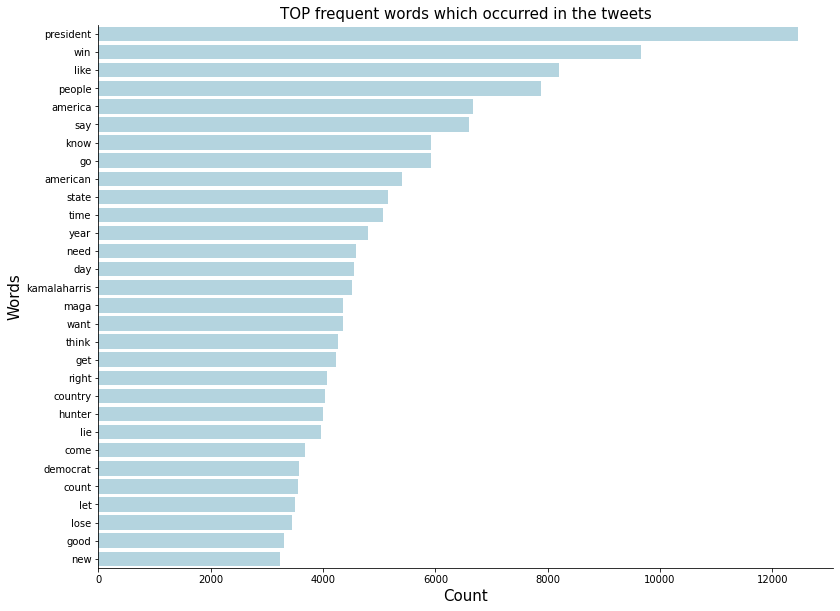

In [22]:
#ploting top 20 words 
plt.figure(figsize=(40,20))
sns.catplot(y="word", x="frequency", kind="bar", color='lightblue', data=df_fdist20, height=8.27, aspect=11.7/8.27)
plt.title('TOP frequent words which occurred in the tweets', size = 15)
plt.xlabel('Count', size = 15)
plt.ylabel('Words', size = 15)
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## 2.2 Wordclouds

#### Creating the wordcloud for the all tweets to visuialize the discourse around the elections

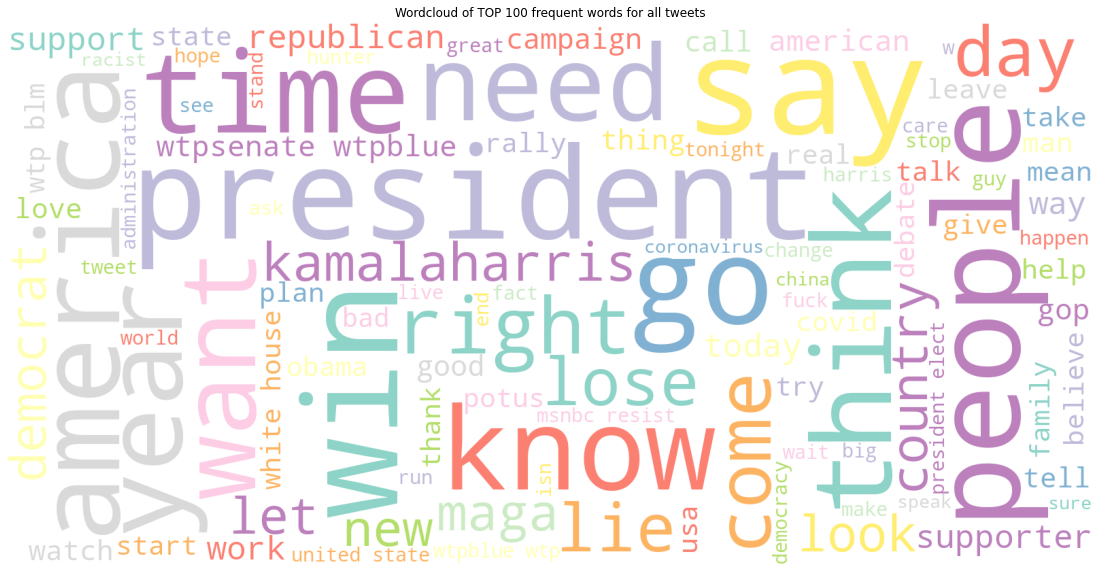

In [23]:
# using list comprehension 
text_wordcloud= ' '.join(map(str, txt_tokens)) 

# Create and generate a word cloud image:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, max_words=100, colormap = 'Set3', background_color="white", collocations=True).generate(text_wordcloud)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title('Wordcloud of TOP 100 frequent words for all tweets')
plt.axis("off")
plt.show()

## 2.3 Bigrams

### Creating the list of the most occured bigrams in the tweets to explore the text deeper 

Text(0.5, 1.0, 'TOP 10 pair of words which occurred the texts')

<Figure size 1440x720 with 0 Axes>

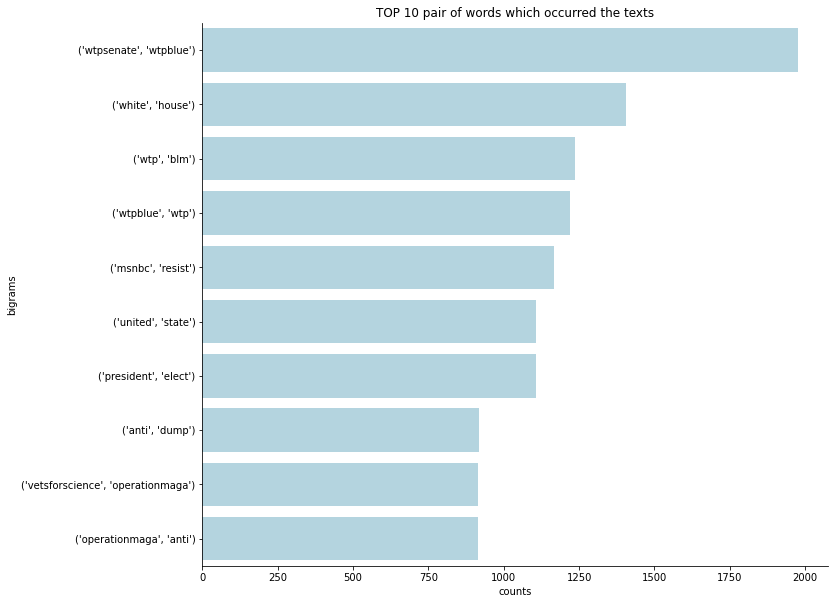

In [28]:
#top 20 bigrams 
bigrams_series = (pd.Series(nltk.ngrams(txt_tokens, 2)).value_counts())[:10]
bigrams_top = pd.DataFrame(bigrams_series.sort_values(ascending=False))
bigrams_top = bigrams_top.reset_index().rename(columns={'index': 'bigrams', 0:'counts'})
bigrams_top
plt.figure(figsize=(20,10))
sns.catplot(x = 'counts' , y='bigrams', kind="bar", color='lightblue', data=bigrams_top, height=8.27, aspect=11.7/8.27)
plt.title('TOP 10 pair of words which occurred the texts')

## 2.5 Date and time analysis

### Minimum and maximum dates in dataframe


In [34]:
print(f" Data Available since {twitter_usa_df.created_at.min()}")
print(f" Data Available upto {twitter_usa_df.created_at.max()}")

 Data Available since 2020-10-15 00:00:02
 Data Available upto 2020-11-08 23:58:44


### Number of tweets according to Dates

In [35]:
twitter_usa_df['created_at'] =  pd.to_datetime(twitter_usa_df['created_at'])
cnt_srs = twitter_usa_df['created_at'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


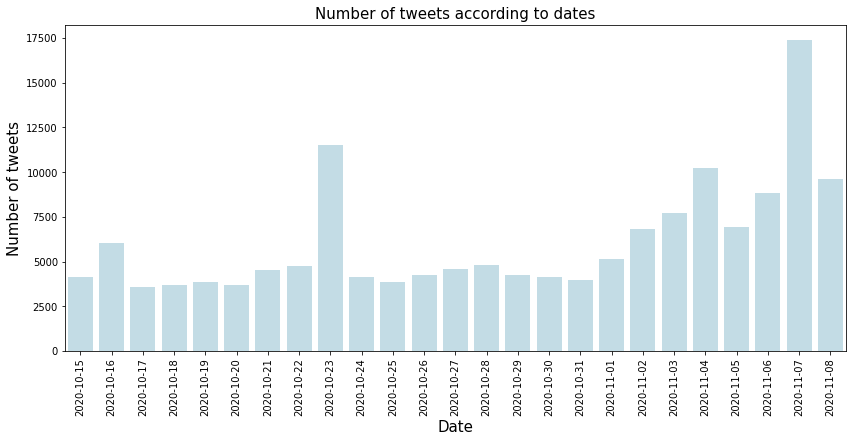

In [36]:
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='lightblue')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.title("Number of tweets according to dates", size = 15)
plt.show()

## 2.6 Tweets popularity analysis

### Most retweeted tweet


In [37]:
tweet_retweet_max = twitter_usa_df.loc[twitter_usa_df['Retweets'].idxmax()]

In [38]:
tweet_retweet_max

created_at                                                                                                                                                                                                                                                           2020-10-16 03:17:29
tweet_id                                                                                                                                                                                                                                                           1316941303603728384.0
tweet               Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.
Likes                                                                                                                                                        

In [39]:
print(f" The tweet '{tweet_retweet_max.tweet}' was retweeted the most with {tweet_retweet_max.Retweets} number of retweets.")


 The tweet 'Tonight a woman in the audience of Trump's town hall began her question by telling him he has a great smile &amp; he's so handsome when he smiles. And when #JoeBiden is President, hopefully that woman will be able to access better vision care, bless her heart.' was retweeted the most with 17652.0 number of retweets.


## 2.7 "Vocal minority" and "silent majority" effect

Mustafaraj et al. 2011 \[1] showed evidence of the existance on social media of a minority of users which are very vocal, while there is a majority of users which hardly produce content.

We explore this phenomenon in our dataset by looking at the distribution of the number of tweets per user.  
The frequency distribution we obtain confirms that there are a small number of users producing a large portion of the tweets for both candidates (the trend is stronger for Biden).  
This indicates that:    
- drawing conclusions about which candidate is preferred based on the number of tweets would be influenced strongly by this small number of very active users.  

In the section dedicated to 'predicting' election results from Tweets, we will see how we can enforce a policy of 'one vote per person' when analysing tweets.  

**\[1]** Eni Mustafaraj, Samantha Finn, Carolyn Whitlock, and Panagiotis Takis Metaxas. **Vocal minority versus silent majority: Discovering the opionions
of the long tail.** In SocialCom/PASSAT, pages 103–110, 2011.


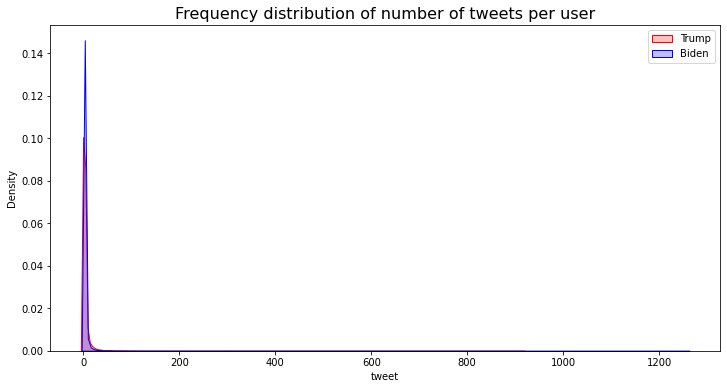

In [40]:
fig, ax=plt.subplots(1,1, figsize=(12,6))

ax.set_title('Frequency distribution of number of tweets per user', fontsize = 16)
sns.kdeplot(trump_usa_df.groupby(['user_id'])['tweet'].count(), shade=True, color='r', label='Trump', ax = ax)
sns.kdeplot(biden_usa_df.groupby(['user_id'])['tweet'].count(), shade=True, color='b', label='Biden', ax = ax)
labels= ["Trump", "Biden"]
ax.legend(labels)
#ax.set_ylim(0, .005)
plt.show()

# 3.  Sentiment Analysis

Sentiment analysis means computing in some way the overall valence of the text. Valence usually means weather a text is negative, neutral or positive.  
Different libraries / algorithms assess text valence in different ways, but this would be the gist of the sentiment analysis.

We identified two popular approaches in performing sentiment analysis:
- **Rule-based** sentiment analysis.  
    This is the simple approach, does not employ machine learning and needs minimal preparation of data in advance.
- **Embedding based** models.  
    This uses words embeddings, an approach where words are represented as vectors of numbers in an n-dimensional space.  

We are going to use three popular libraries in this Notebook:
- **TextBlob**
- **VADER (included in the Natural Language Toolkit - nltk)**
- **Flair**


First, we clean our data.
For lemmatization, different libraries give slightly different results.
For an extensive comparison, see this article: https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

In [41]:
'''
first we will perform 'cleaning' of the tweets: remove unnecessary words (stopwords and two letter words), punctuation etc 
'''
import nltk
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Import word_tokenize and stopwords from nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Install spaCy (run in terminal/prompt)
import sys
!{sys.executable} -m pip install spacy

# Download spaCy's  'en' Model
!{sys.executable} -m spacy download en

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def clean_text_2(tweet, lemmatize = 'nltk'):
    '''
    input:
      - tweet = a string representing the text you need to clean
      - lemmatize = {spacy, nltk} 
      two lemmatization methods
      with our dataset, we got the best results with nltk
      but Spacy also did a good job, hence you might 
      try both and compare results for your data
    out: 
      - the cleaned text, tokenized (a list of string words)
    '''

    # lowercase
    tweet = tweet.lower()
    
    # Remove links
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove mentions and the hashtag character
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # remove stopwords with Gensim
    tweet=remove_stopwords(tweet)

    if (lemmatize == 'spacy'):
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(tweet)
        tokenized = [token.lemma_ for token in doc if token.lemma_ != '-PRON-']
    elif (lemmatize == 'nltk'): 
        '''
        lemmatization works best when WordNetLemmatizer receives both the text and the part of speech of each word
        the code below assigns POS (part of speech) tag on a per word basis (it does not infer POS from contenxt / sentence), which might not be optimal
        '''
        lemmatizer = WordNetLemmatizer()
        tokenized = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(tweet)]
    
    # Remove the stop words with NLTK
    # to make sure no unimportant words are left
    tokenized = [token for token in tokenized if token not in stopwords.words("english")] 

    # Remove non-alphabetic characters and keep the words contains three or more letters
    tokenized = [token for token in tokenized if token.isalpha() and len(token)>2]

    #non_tokenized = ' '.join([w for w in tokenized])
        
    return tokenized

def combine_tokens(tokenized): 
  
    non_tokenized = ' '.join([w for w in tokenized])
  
    return non_tokenized


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 29.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Perform a quick test to see which lemmatizer performs best on our data

In [42]:
'''
temp = twitter_usa_df.head(20).copy()

import time
start =  time.time()

temp['tokenized_tweet_spacy'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'spacy'))
temp['clean_tweet_spacy'] = temp['tokenized_tweet_spacy'].apply(lambda x: combine_tokens(x))

temp['tokenized_tweet_nltk'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))
temp['clean_tweet_nltk'] = temp['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))

stop = time.time()
print('Cleaning tweets takes this many minutes: ', round((stop-start)/60, 3))
'''

"\ntemp = twitter_usa_df.head(20).copy()\n\nimport time\nstart =  time.time()\n\ntemp['tokenized_tweet_spacy'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'spacy'))\ntemp['clean_tweet_spacy'] = temp['tokenized_tweet_spacy'].apply(lambda x: combine_tokens(x))\n\ntemp['tokenized_tweet_nltk'] = temp['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))\ntemp['clean_tweet_nltk'] = temp['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))\n\nstop = time.time()\nprint('Cleaning tweets takes this many minutes: ', round((stop-start)/60, 3))\n"

In [43]:
#uncomment the line below if you want to run your own test
#to keep the output short, we commented it out after running the test 
#and we present the results in a stylized screeshot 
#temp[['tweet', 'clean_tweet_spacy', 'clean_tweet_nltk']]

Each lemmatizer seems to have its hits and misses. Since the difference is not that big, we decided after visual inspection to continue with nltk



Cleaning our tweets

In [44]:
import time
start =  time.time()
twitter_usa_df['tokenized_tweet_nltk'] = twitter_usa_df['tweet'].apply(lambda x: clean_text_2(x, 'nltk'))
twitter_usa_df['clean_tweet_nltk'] = twitter_usa_df['tokenized_tweet_nltk'].apply(lambda x: combine_tokens(x))
stop = time.time()
print('Cleaning all tweets takes this many minutes: ', round((stop-start)/60, 3))

trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

Cleaning all tweets takes this many minutes:  10.845


## 3.1 Sentiment analysis using TextBlob

According to [TextBlob's official website](https://textblob.readthedocs.io/en/dev/), TextBlob "provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more."

TextBlob library will output something like this for each snippet of text that it analyzes:  
_Sentiment(polarity=-0.125, subjectivity=0.5916666666666667)_

That is, TextBlob will output:
- a measure of polarity, which can have values in the interval \[-1, 1\]
- an estimation of subjectivity, ranging is \[0.0, 1.0\] where 0.0 is very objective (dealing with facts) and 1.0 is very subjective (opinions). 

Interpreting the results:  
- TextBlob documentation does not give precise guidelines for interpreting the numberic output ([see TextBlob ReadTheDocs section for Sentiment analysis here](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis))
- We will adopt the approach we encountered in [this KDNuggets post](https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html):  
  - we will label <0 values as 'negative' 
  - 0 values as 'neutral' 
  - and \>0 values as 'positive' 

Function for labelling tweets based on classification criteria described above.

In [45]:
# Helper Function to assign Label for Sentiment Analysis with TextBlob
def create_sentiment_labels(df, feature,value):
    '''
    in: 
        dataframe 
        value on which to classify
        feature - column name of the feature that receives the label
    out: 
        does not return a value
        modifies the dataframe received as parameter
    '''

    df.loc[df[value] > 0,feature] = 'positive'
    df.loc[df[value] == 0,feature] = 'neutral'
    df.loc[df[value] < 0,feature] = 'negative'

In [46]:
# Polarity and subjectivity
def sentiment_analysis(dataframe):
    dataframe['blob_polarity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.polarity)
    dataframe['blob_subjectivity'] = dataframe['clean_tweet_nltk'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    create_sentiment_labels(dataframe, 'blob_sentiment','blob_polarity')
    
    return dataframe[['clean_tweet_nltk','blob_polarity','blob_subjectivity','blob_sentiment']].head()   

In [47]:
import time
start =  time.time()

sentiment_analysis(twitter_usa_df)

stop = time.time()
print('Sentiment analysis with TextBlob took: ', round((stop-start)/60, 3))

#update the divided dataset
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

Sentiment analysis with TextBlob took:  0.797


### 3.1.1 Different ways to look at the same data.  

#### Option a

In the next plot, we will compute an average polarity per candidate as follows:  
- we simply average the polarity feature computed by TextBlob across all tweets per candidate. 

Issues with this approach:  
- imagine we have 1 user who tweeted 99 times, each having polarity -1 (a candidate opposer). And 1 user who tweeted once with polarity 1 (a candidate supporter). If we average across all tweets, we obtain **-0.98**.  
What can we infer from this result ? 
- inferring support / opposing for the candidate would be wrong, since in our sample we actually have one opposant and 1 supporter.
- we can only infer the trivial: that the result is just the average sentiment across all tweets.

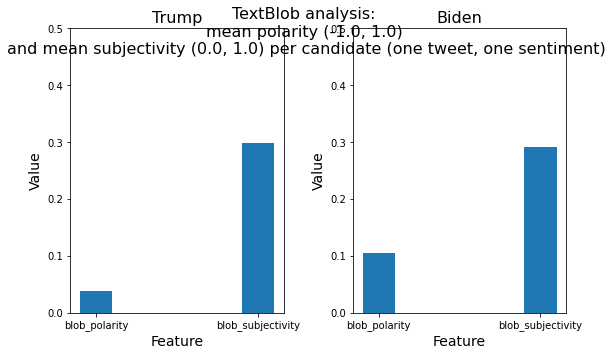

In [48]:
#update the divided dataset
trump_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='trump']
biden_usa_df = twitter_usa_df[twitter_usa_df.initial_dataset=='biden']

fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob analysis: \nmean polarity (-1.0, 1.0) \nand mean subjectivity (0.0, 1.0) per candidate (one tweet, one sentiment)', fontsize=16)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 14)

values = [biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 14)

fig.tight_layout()
plt.show()

trump_usa_pol_tweet =trump_usa_df['blob_polarity'].mean()
trump_usa_subj_tweet = trump_usa_df['blob_subjectivity'].mean()
biden_usa_pol_tweet = biden_usa_df['blob_polarity'].mean()
biden_usa_subj_tweet = biden_usa_df['blob_subjectivity'].mean()

#### Option b  

Another option is to:
- first average sentiment expressed through tweets per user id -> we will have one averge expressed sentiment per user per candidate
- then avergae across the whole population for each candidate

Number of users who tweeted about Trump:  21049
Number of users who tweeted about Biden:  28482


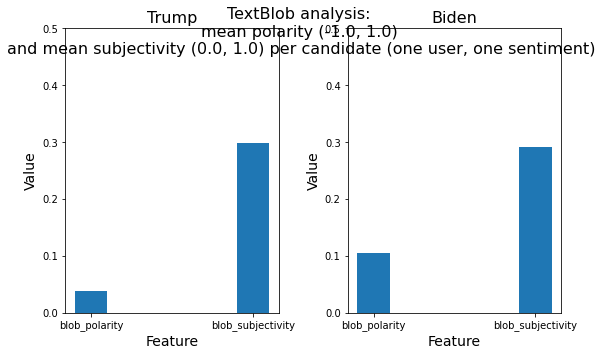

In [49]:
#how many users tweeted about trump
print('Number of users who tweeted about Trump: ', trump_usa_df.user_id.nunique())
print('Number of users who tweeted about Biden: ', biden_usa_df.user_id.nunique())

# the below gives us a mean per user
# trump_usa_df[['user_id', 'Polarity']].groupby(['user_id'])['Polarity'].mean()

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('TextBlob analysis: \nmean polarity (-1.0, 1.0) \nand mean subjectivity (0.0, 1.0) per candidate (one user, one sentiment)', fontsize=16)

features = ['blob_polarity', 'blob_subjectivity']
values = [trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[0].bar(features,values, width=0.2,)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Value', fontsize = 14)

values = [biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean(), biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()]
axes[1].bar(features,values, width=0.2,)
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Value', fontsize = 14)

fig.tight_layout()
plt.show()

trump_usa_pol_user = trump_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean()
trump_usa_subj_user = trump_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()
biden_usa_pol_user = biden_usa_df.groupby(['user_id'])['blob_polarity'].mean().mean()
biden_usa_subj_user = biden_usa_df.groupby(['user_id'])['blob_subjectivity'].mean().mean()

### Let's see how our results are influenced by choosing either of the two options mentioned above


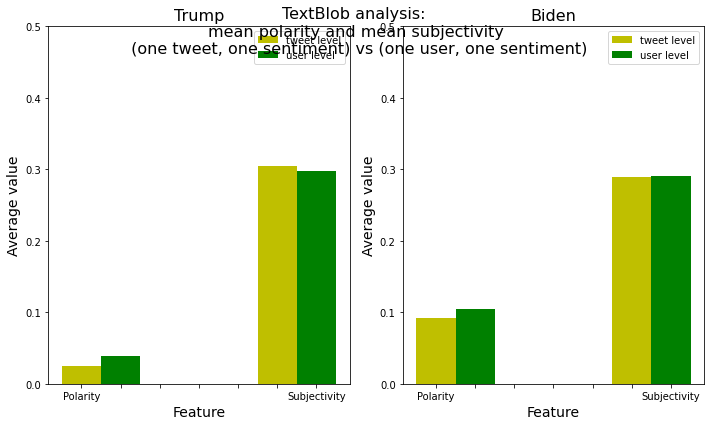

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))

fig.suptitle('TextBlob analysis: \nmean polarity and mean subjectivity\n (one tweet, one sentiment) vs (one user, one sentiment)', fontsize=16)

#features = ['Polarity', 'Subjectivity']
features = np.array([1, 2])
values_tweet = [ trump_usa_pol_tweet, trump_usa_subj_tweet]
values_user = [ trump_usa_pol_user, trump_usa_subj_user]

#values = [[trump_usa_pol_tweet, trump_usa_subj_tweet], 
#[trump_usa_pol_user, trump_usa_subj_user]]

axes[0].bar(features-0.2, values_tweet, width=0.2, align = 'center', color = 'y')
axes[0].bar(features, values_user, width=0.2, align = 'center', color = 'g')
#axes[0].bar(features,values)
axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Feature', fontsize = 14)
axes[0].set_ylabel('Average value', fontsize = 14)
axes[0].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])
labels= ["tweet level", "user level"]
axes[0].legend(labels)

values_tweet = [ biden_usa_pol_tweet, biden_usa_subj_tweet]
values_user = [ biden_usa_pol_user, biden_usa_subj_user]
axes[1].bar(features-0.2,values_tweet, width=0.2, align = 'center', color = 'y')
axes[1].bar(features,values_user, width=0.2, align = 'center', color = 'g')
axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Feature', fontsize = 14)
axes[1].set_ylabel('Average value', fontsize = 14)
axes[1].set_xticklabels(['', 'Polarity', '', '', '', '', '', 'Subjectivity'])

labels= ["tweet level", "user level"]
axes[1].legend(labels)

fig.tight_layout()
plt.show()

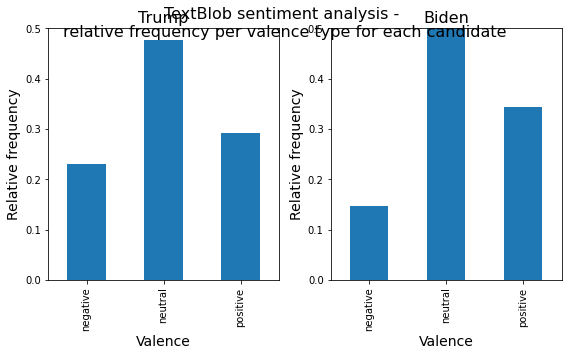

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))

fig.suptitle('TextBlob sentiment analysis - \nrelative frequency per valence type for each candidate', fontsize=16)
(trump_usa_df['blob_sentiment'].sort_values().value_counts()/trump_usa_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']].plot(kind='bar', ax = axes[0])

axes[0].set_ylim(0, .5)
axes[0].set_title('Trump', fontsize = 16)
axes[0].set_xlabel('Valence', fontsize = 14)
axes[0].set_ylabel('Relative frequency', fontsize = 14)

(biden_usa_df['blob_sentiment'].sort_values().value_counts()/biden_usa_df['blob_sentiment'].shape[0])[['negative', 'neutral', 'positive']].plot(kind='bar', ax = axes[1])

axes[1].set_ylim(0, .5)
axes[1].set_title('Biden', fontsize = 16)
axes[1].set_xlabel('Valence', fontsize = 14)
axes[1].set_ylabel('Relative frequency', fontsize = 14)

fig.tight_layout()
plt.show()


## 5. Topic modeling: Latent Dirichlet Allocation (LDA)


LDA is an unsupervised machine learning algorithm. It allows a set of observations to be explained by unobserved groups that explain similarities within the data.

![Picture title](image-20210120-154824.png)

We will use the topic modeling to create and visualize the topics which shape the discourse around the elections. 
We start with finding the optimal number of topics for our dataset. Trying out the different numbers of topics and comparing the coherence score for each model.

In [58]:
twitter_usa_df.shape

(152376, 28)

In [59]:
#subseting and preparing data for TM
#data_sample = twitter_usa_df.sample(n = 1000)
data_sample = twitter_usa_df.sample(n = 1000)

In [60]:
# Create Dictionary
tweets_dictionary = corpora.Dictionary(data_sample.tokenized_tweets)

# Create Corpus
texts = twitter_usa_df.tokenized_tweets

# Term Document Frequency
tweets_corpus = [tweets_dictionary.doc2bow(text) for text in texts]

# compute coherence
tweets_coherence = []
for nb_topics in range(4,14):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10,random_state=100)
    #cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass') #u_mass
    cohm = CoherenceModel(model=lda, texts=twitter_usa_df.tokenized_tweets, dictionary=tweets_dictionary, coherence='c_v') 
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

Text(0, 0.5, 'Coherence Score')

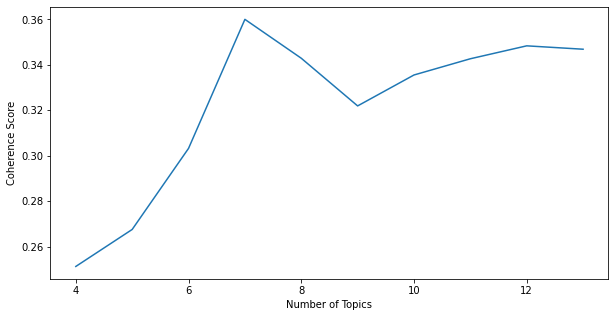

In [61]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(4,14),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

The optional number of topics according to the coherence score is 12.

In [62]:
vectorizer = CountVectorizer( analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
)


In [63]:
data_matrix = vectorizer.fit_transform(twitter_usa_df.lemmat_tweets)
data_matrix

<152376x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1156703 stored elements in Compressed Sparse Row format>

In [64]:
lda_model = LatentDirichletAllocation(
n_components=12, # Number of topics
learning_method='online',
random_state=62,       
n_jobs = -1  # Use all available CPUs
)

lda_output = lda_model.fit_transform(data_matrix)

In [65]:
pyLDAvis.enable_notebook()
p = pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')
pyLDAvis.save_html(p, 'lda.html')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

In [66]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i + 1}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Top 10 words for topic #1:
['win', '000', 'stop', 'lead', 'new', 'lie', 'elect', 'count', 'kamalaharris', 'president']


Top 10 words for topic #2:
['real', 'look', 'time', 'say', 'think', 'country', 'like', 'year', 'state', 'win']


Top 10 words for topic #3:
['night', 'demcast', 'bad', 'medium', 'gop', 'news', 'obama', 'pennsylvania', 'watch', 'need']


Top 10 words for topic #4:
['true', 'nevada', 'anti', 'fraud', 'woman', 'cnn', 'fuck', 'blm', 'dump', 'presidentelect']


Top 10 words for topic #5:
['arizona', 'wtp', 'florida', 'resist', 'covid', 'msnbc', 'georgia', 'wtpsenate', 'covid19', 'love']


Top 10 words for topic #6:
['rally', 'end', 'read', 'kamala', 'care', 'world', 'usa', 'democracy', 'campaign', 'day']


Top 10 words for topic #7:
['say', 'tax', 'know', 'believe', 'live', 'china', 'life', 'people', 'man', 'come']


Top 10 words for topic #8:
['republican', 'plan', 'want', 'black', 'president', 'maga', 'supporter', 'democrat', 'harris', 'america']


Top 10 words for topi

## 5.1 Predictive model for the new tweets

In the last step, we add a new created topic column to the input dataframe and assign to each row ,based on the probability value, the suitable topic. To find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.

In [67]:
topic_values = lda_model.transform(data_matrix)
twitter_usa_df['Topic'] = topic_values.argmax(axis=1)

Let’s see which topic has been assigned to each tweet

In [68]:
twitter_usa_df[['tweet', 'Topic']].head(5)

,tweet,Topic
0,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",1
1,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,6
3,#Trump #PresidentTrump #Trump2020LandslideVictory #Trump2020 #MAGA #KAG #4MoreYears #America #AmericaFirst #AllLivesMatter #Winning #Vote #VoteInPerson #VoteTrump #VotePresidentTrump https://t.co/TzXBKOvgNs,7
4,"#Trump: Nobody likes to tell you this, but some of the farmers were doing better the way I was doing it than they were by working their asses off.\n\nAnd that check? It's totally in the mail, right Don?",8
6,@karatblood @KazePlays_JC Grab @realDonaldTrump by the balls &amp; chuck the bastard out the door onto #PennsylvaniaAvenue &amp; form a line &amp; everybody gets to kick #DonaldTrump in the nuts! Please note 1 kick per person only! #BidenHarrisToSaveAmerica #VoteBlueToSaveOurDemocracy,8
